# CNN

## Convolutional Layerのスクラッチ実装

In [138]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torch.nn import functional as F
import time
%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
dataset = torchvision.datasets.MNIST(root = './mnist_data', train = True, download = True)
im, label = dataset[0]
im = transforms.ToTensor()(im)[0, :, :]

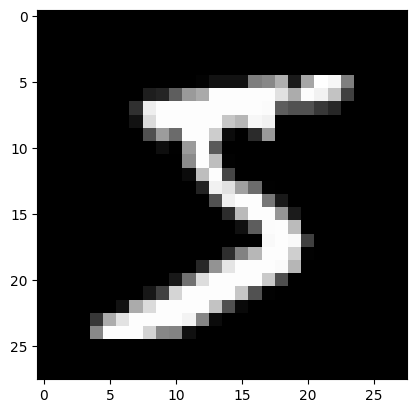

In [85]:
plt.imshow(im, cmap = 'gray')

In [27]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data
    Split: Train

In [88]:
upper_edge_filter = torch.tensor([[-1., -1., -1.],
                                 [0., 0., 0.],
                                 [1., 1., 1.]])
left_edge_filter = torch.tensor([[-1., 0., 1.],
                                 [-1., 0., 1.],
                                 [-1., 0., 1.]])

def convolution(im, filter):
    feature_map = torch.zeros((im.shape[0] - filter.shape[0]-1, im.shape[1] - filter.shape[1]-1))
    for n in range(im.shape[0] - filter.shape[0]-1):
        for i in range(im.shape[1] - filter.shape[1]-1):
            feature_map[n, i] = torch.sum(im[n:n+filter.shape[0], i:i+filter.shape[1]] @ filter)
    return feature_map

feature_map = convolution(im, upper_edge_filter)

In [68]:
feature_map.shape

torch.Size([26, 26])

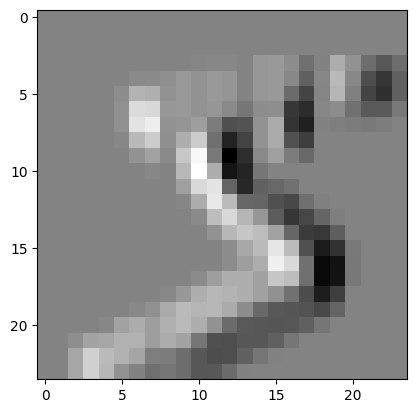

In [89]:
# upper edge filter
plt.imshow(feature_map, cmap = 'gray') 

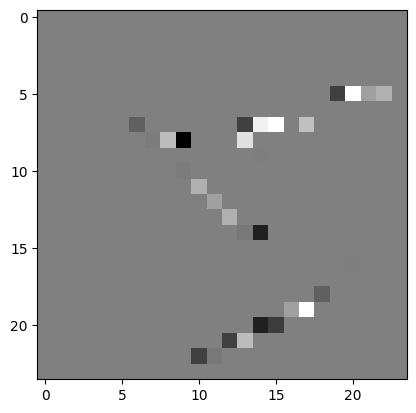

In [87]:
# left edge filter
plt.imshow(feature_map, cmap = 'gray')

In [82]:
feature_map = torch.zeros((26, 26))
feature_map.shape

torch.Size([26, 26])

## CNN構築

In [141]:
conv_model = nn.Sequential(
    # 1×28×28
    nn.Conv2d(1, 4, kernel_size = 3, stride = 2, padding = 1),
    nn.ReLU(),
    # 4×14×14
    nn.Conv2d(4, 8, kernel_size = 3, stride = 2, padding = 1),
    nn.ReLU(),
    # 8×7×7
    nn.Conv2d(8, 16, kernel_size = 3, stride = 2, padding = 1), # 奇数の場合は繰り上がったサイスで出力される
    nn.ReLU(),
    # 16×4×4
    nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1),
    nn.ReLU(),
    # 32×2×2
    # nn.flatten()
    # # 128
    # nn.Linear(128, 10)
    nn.Conv2d(32, 10, kernel_size = 3, stride = 2, padding = 1),
    # 10×1×1
    nn.Flatten()
    # 10
)

In [97]:
conv_model

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [98]:
X = torch.randn((8, 1, 28, 28))
output = conv_model(X)

In [99]:
output

tensor([[-7.0689e-02,  6.1168e-02, -5.3871e-02, -7.4455e-02,  3.2488e-02,
          3.1415e-02, -4.3814e-02, -1.6877e-02,  3.0845e-02,  8.4458e-03],
        [-7.2078e-02,  6.3393e-02, -4.3798e-02, -7.5886e-02,  2.8349e-02,
          3.6379e-02, -4.8181e-02, -1.5627e-02,  3.0007e-02,  6.4423e-03],
        [-6.9026e-02,  6.2565e-02, -5.8965e-02, -7.0220e-02,  3.6907e-02,
          2.7884e-02, -4.4056e-02, -1.2323e-02,  2.8474e-02,  7.3341e-03],
        [-7.4321e-02,  6.4814e-02, -4.3407e-02, -7.0797e-02,  2.9283e-02,
          3.9846e-02, -4.6687e-02, -1.3118e-02,  2.8098e-02, -4.5247e-05],
        [-6.6513e-02,  6.6461e-02, -5.2165e-02, -7.1781e-02,  3.4516e-02,
          4.0103e-02, -3.8834e-02, -1.6528e-02,  3.6890e-02,  2.3783e-03],
        [-7.7849e-02,  5.8134e-02, -4.9508e-02, -7.3147e-02,  3.7872e-02,
          3.5493e-02, -4.3187e-02, -1.2807e-02,  3.0599e-02,  8.4280e-03],
        [-7.4159e-02,  6.5312e-02, -5.3097e-02, -7.1799e-02,  3.2260e-02,
          3.0328e-02, -4.4714e-0

In [101]:
output.shape

torch.Size([8, 10])

In [106]:
torch.tensor([params.numel() for params in conv_model.parameters()]).sum()

tensor(9034)

In [146]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root = './mnist_data', train = True, download = True, transform = transform)
val_dataset = torchvision.datasets.MNIST(root = './mnist_data', train = False, download = True, transform = transform)
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = 128, num_workers = 4)

# GPUで処理する場合は以下
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_model.to(device)

conv_model = nn.Sequential(
    # 1×28×28
    nn.Conv2d(1, 4, kernel_size = 3, stride = 2, padding = 1),
    nn.ReLU(),
    # 4×14×14
    nn.Conv2d(4, 8, kernel_size = 3, stride = 2, padding = 1),
    nn.ReLU(),
    # 8×7×7
    nn.Conv2d(8, 16, kernel_size = 3, stride = 2, padding = 1), # 奇数の場合は繰り上がったサイスで出力される
    nn.ReLU(),
    # 16×4×4
    nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1),
    nn.ReLU(),
    # 32×2×2
    # nn.flatten()
    # # 128
    # nn.Linear(128, 10)
    nn.Conv2d(32, 10, kernel_size = 3, stride = 2, padding = 1),
    # 10×1×1
    nn.Flatten()
    # 10
)
opt = optim.SGD(conv_model.parameters(), lr = 0.03)
start = time.time()
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, loss_func = F.cross_entropy, num_epoch = 10)
end = time.time()
print(f'time : {end - start}')

epoch: 0: train error: 2.2926548467770314, validation error: 2.2582084951521475, validation accuracy: 0.13419699367088608


epoch: 1: train error: 1.0157873457047477, validation error: 0.35692121824131734, validation accuracy: 0.8947784810126582


epoch: 2: train error: 0.31069381983041255, validation error: 0.24730900194071517, validation accuracy: 0.9283030063291139


epoch: 3: train error: 0.22521820348272445, validation error: 0.1814605892411893, validation accuracy: 0.944620253164557


epoch: 4: train error: 0.18098366557598622, validation error: 0.154505132768256, validation accuracy: 0.9525316455696202


epoch: 5: train error: 0.15360402120456004, validation error: 0.14857105337543106, validation accuracy: 0.9529272151898734


epoch: 6: train error: 0.13523913557325473, validation error: 0.12264044129855553, validation accuracy: 0.9623219936708861


epoch: 7: train error: 0.12013454070842977, validation error: 0.11824837443713523, validation accuracy: 0.9625197784810127


epoch: 8: train error: 0.11060176446620844, validation error: 0.12312892227303944, validation accuracy: 0.9611352848101266


epoch: 9: train error: 0.10257643820650415, validation error: 0.11872704181808365, validation accuracy: 0.9604430379746836
time : 45.56822752952576


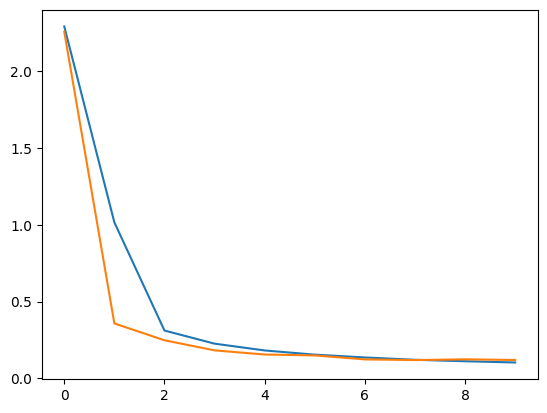

In [147]:
plt.plot(train_losses)
plt.plot(val_losses)